In [ ]:
import sys

sys.path.append("../..")

import pandas as pd

import src.preprocessing.functions as preprocessing_functions

data_root_dir = "../../data/sun_et_al_data/"


def print_full_df(x):
    pd.set_option("display.max_rows", None)
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", None)
    pd.set_option("display.max_colwidth", None)
    display(x)
    pd.reset_option("display.max_rows")
    pd.reset_option("display.max_columns")
    pd.reset_option("display.width")
    pd.reset_option("display.float_format")
    pd.reset_option("display.max_colwidth")


def do_necessary_preprocessing(
    sample_group, mpa4_species_profile, do_filtering: bool = False
):
    studies_to_remove = ["LiS_2021a", "LiS_2021b"]
    columns_to_keep = ["Sample", "Group", "Project", "Project_1"]
    # Remove studies
    sample_group = sample_group[~sample_group["Project_1"].isin(studies_to_remove)]

    # Keep recommended columns
    sample_group = sample_group[columns_to_keep]
    # Set index to Sample
    sample_group = sample_group.set_index("Sample")

    # Remove species with no reads
    mpa4_species_profile = mpa4_species_profile.loc[
        :, mpa4_species_profile.sum(axis=0) >= 1
    ]

    ## Remove repeated samples
    sample_group = sample_group[~sample_group.index.duplicated(keep="first")]

    # remove samples not in sample_group
    samples_to_keep = list(
        set(sample_group.index.tolist()) & set(mpa4_species_profile.columns.tolist())
    )
    mpa4_species_profile = mpa4_species_profile[samples_to_keep]

    mpa4_species_profile = mpa4_species_profile.T

    # remove samples from sample_group that are not in mpa4_species_profile
    sample_group = sample_group.loc[samples_to_keep]

    if do_filtering:
        # Normalize the data
        mpa4_species_profile = preprocessing_functions.total_sum_scaling(
            mpa4_species_profile
        )

        # prevalence and abundance filtering
        # low abundance filtering per study
        grouped_sample_group = sample_group.groupby("Project_1")
        display(mpa4_species_profile)
        for project, samples in grouped_sample_group.groups.items():
            rows_to_update = mpa4_species_profile.loc[samples]
            feature_prevalence = (rows_to_update > 0.0001).sum(
                axis=0
            ) / rows_to_update.shape[0]
            low_abundance_features = feature_prevalence < 0.1

            df_masked = rows_to_update.mask(
                low_abundance_features | (rows_to_update <= 0.0001), 0
            )
            mpa4_species_profile.update(df_masked)

    return sample_group, mpa4_species_profile


# getting data
## not preprocessed data
mpa4_species_profile = pd.read_table(
    f"{data_root_dir}/mpa4_species.profile", sep="\t", header=0, index_col=0
)
sample_group = pd.read_table(f"{data_root_dir}/sample.group", sep="\t", header=0)
### we still need to remove samples without metadata, and some other stuff
sample_group, mpa4_species_profile = do_necessary_preprocessing(
    sample_group, mpa4_species_profile
)

mpa4_species_profile_preprocessed = pd.read_table(
    f"{data_root_dir}/mpa4_species.profile", sep="\t", header=0, index_col=0
)
sample_group_preprocessed = pd.read_table(f"{data_root_dir}/sample.group", sep="\t", header=0)
sample_group_preprocessed, mpa4_species_profile_preprocessed = (
    do_necessary_preprocessing(sample_group_preprocessed, mpa4_species_profile_preprocessed, do_filtering=True)
)

# Decreasing feature space by focusing on specific species
species_to_keep = [
    "s__Phocaeicola_vulgatus",
    "s__Prevotella_copri_clade_A",
    "s__Faecalibacterium_prausnitzii",
    "s__Bacteroides_uniformis",
    "s__Phocaeicola_plebeius",
    "s__Bacteroides_stercoris",
    "s__Phocaeicola_dorei",
    "s__Alistipes_putredinis",
    "s__Eubacterium_rectale",
    "s__Escherichia_coli",
    "s__Bacteroides_ovatus",
    "s__Bacteroides_fragilis",
    "s__Phocaeicola_coprocola",
    "s__Prevotella_copri_clade_C",
    "s__Megamonas_funiformis",
    "s__Ruminococcus_bromii",
    "s__Bacteroides_thetaiotaomicron",
    "s__Roseburia_faecis",
    "s__Phocaeicola_massiliensis",
    "s__Parabacteroides_distasonis",
]

# mpa4_species_profile_desired = mpa4_species_profile[species_to_keep]
# others = mpa4_species_profile[list(set(mpa4_species_profile.columns) - set(species_to_keep))]
# others = pd.DataFrame(others.sum(axis=1), columns=["other"])
# mpa4_species_profile_desired = pd.concat([mpa4_species_profile_desired, others], axis=1, join="outer")
# mpa4_species_profile = mpa4_species_profile_desired
# del mpa4_species_profile_desired
# del others

# mpa4_species_profile_desired = mpa4_species_profile_preprocessed[species_to_keep]
# others = mpa4_species_profile_preprocessed[list(set(mpa4_species_profile_preprocessed.columns) - set(species_to_keep))]
# others = pd.DataFrame(others.sum(axis=1), columns=["other"])
# mpa4_species_profile_desired = pd.concat([mpa4_species_profile_desired, others], axis=1, join="outer")
# mpa4_species_profile_preprocessed = mpa4_species_profile_desired
# del mpa4_species_profile_desired
# del others

print("Not preprocessed data")
print(mpa4_species_profile.shape, sample_group.shape)
display(mpa4_species_profile.head())
display(sample_group.head())

print("Preprocessed data")
print(mpa4_species_profile_preprocessed.shape, sample_group_preprocessed.shape)
display(mpa4_species_profile_preprocessed.head())
display(sample_group_preprocessed.head())


KeyboardInterrupt: 

: 

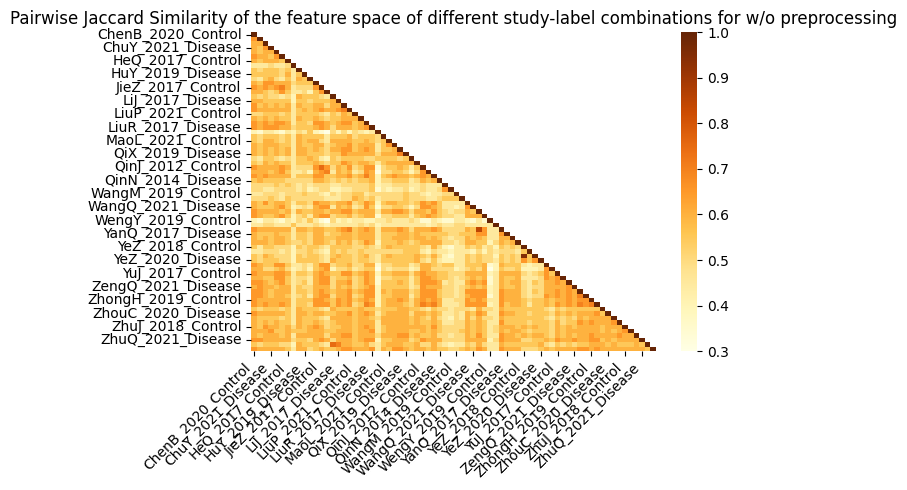

Value counts of pairwise Jaccard Similarity of the feature space of different study-label combinations for w/o preprocessing


0
0.60    735
0.55    694
0.50    443
0.45    307
0.65    247
0.40     83
1.00     72
0.35     25
0.70     13
0.30      5
0.75      2
0.85      1
0.95      1
Name: count, dtype: int64

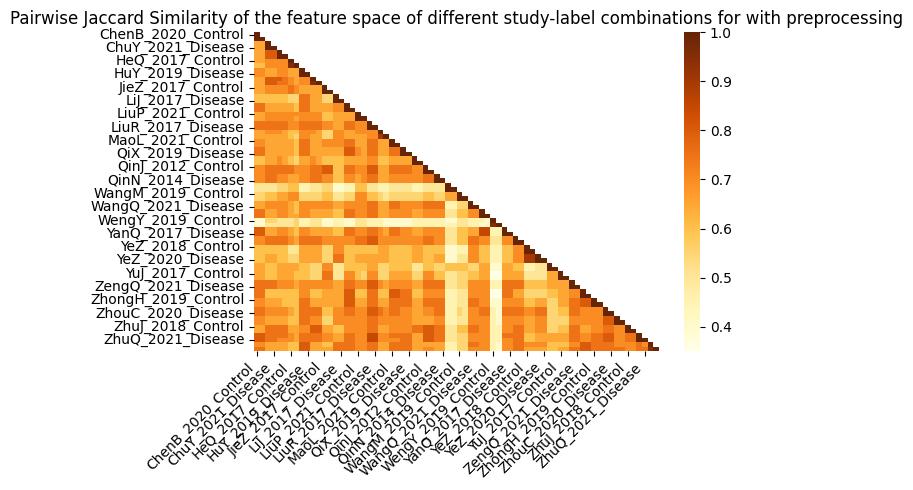

Value counts of pairwise Jaccard Similarity of the feature space of different study-label combinations for with preprocessing


0
0.70    640
0.65    542
0.75    442
0.60    334
0.55    157
0.50    136
0.45    111
1.00    103
0.80     85
0.40     53
0.35      8
0.85      8
0.90      5
0.95      4
Name: count, dtype: int64

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


def jaccard_similarity_after_studywise_labelwise_grouping(
    data, metadata, addition_to_title
):
    grouped_by_project = metadata.groupby(metadata["Project_1"])
    studywise_labelwise_nonzero_features = {}

    for group, group_df in grouped_by_project:
        for label, indices in group_df.groupby("Group").groups.items():
            df = data.loc[indices]
            df_filtered = df.loc[:, (df.abs().sum(axis=0) != 0)]
            studywise_labelwise_nonzero_features[f"{group}_{label}"] = set(
                list(df_filtered.columns)
            )

    keys = list(studywise_labelwise_nonzero_features.keys())
    n = len(keys)
    jaccard_mat = np.zeros((n, n))

    # Jaccard similarity calculation: defined as: |A ∩ B| / |A ∪ B|
    for i in range(n):
        for j in range(n):
            set1 = studywise_labelwise_nonzero_features[keys[i]]
            set2 = studywise_labelwise_nonzero_features[keys[j]]
            # Calculate the intersection and union sizes:
            intersection_size = len(set1.intersection(set2))
            union_size = len(set1.union(set2))
            # Avoid division by zero
            jaccard_mat[i, j] = (
                intersection_size / union_size if union_size > 0 else np.nan
            )

    # Create a DataFrame from the matrix for easier plotting
    jaccard_df = pd.DataFrame(jaccard_mat, index=keys, columns=keys)

    # Plot a heatmap using seaborn
    def round_nearest(x, a):
        return round(x / a) * a

    jaccard_df_rounded = round_nearest(jaccard_df, 0.05).where(
        np.tril(np.ones(jaccard_df.shape)).astype(np.bool)
    )
    plt.figure(figsize=(7, 5))
    sns.heatmap(
        jaccard_df_rounded,
        annot=False,
        cmap=sns.color_palette("YlOrBr", as_cmap=True),
        fmt=".1f",
    )
    plt.title(
        f"Pairwise Jaccard Similarity of the feature space of different study-label combinations for {addition_to_title}"
    )
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    jaccard_df_rounded = jaccard_df_rounded.stack().reset_index()
    print(
        f"Value counts of pairwise Jaccard Similarity of the feature space of different study-label combinations for {addition_to_title}"
    )
    print_full_df(jaccard_df_rounded[0].value_counts())


jaccard_similarity_after_studywise_labelwise_grouping(
    mpa4_species_profile, sample_group, "w/o preprocessing"
)
jaccard_similarity_after_studywise_labelwise_grouping(
    mpa4_species_profile_preprocessed, sample_group_preprocessed, "with preprocessing"
)

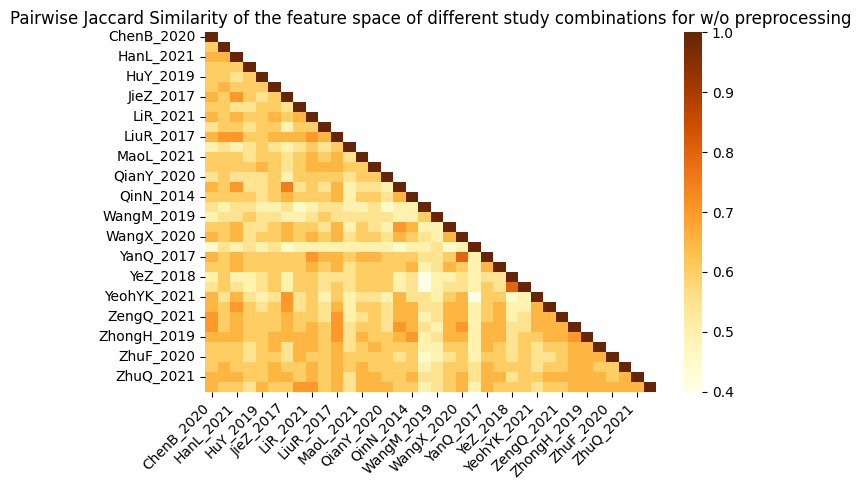

Value counts of pairwise Jaccard Similarity of the feature space of different study combinations for w/o preprocessing


0
0.60    237
0.65    147
0.55    130
0.50     81
1.00     36
0.70     21
0.45      8
0.40      3
0.80      2
0.75      1
Name: count, dtype: int64

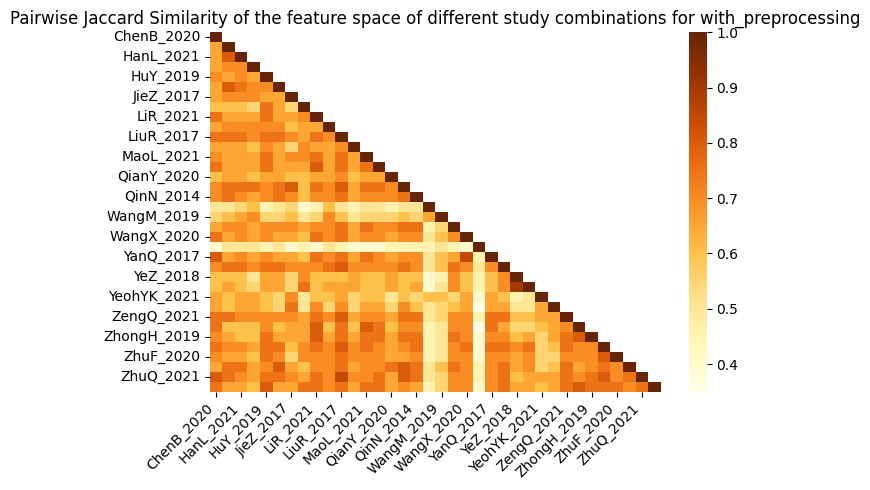

Value counts of pairwise Jaccard Similarity of the feature space of different study combinations for with_preprocessing


0
0.70    158
0.65    143
0.75    110
0.60     79
0.55     37
0.50     36
1.00     36
0.45     26
0.80     21
0.40     15
0.85      2
0.35      2
0.90      1
Name: count, dtype: int64

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


def jaccard_similarity_after_studywise_grouping(data, metadata, addition_to_title):
    grouped_by_project = metadata.groupby(metadata["Project_1"])
    studywise_nonzero_features = {}

    for group, idx in grouped_by_project.groups.items():
        df = data.loc[idx]
        df_filtered = df.loc[:, (df.abs().sum(axis=0) != 0)]
        studywise_nonzero_features[group] = set(list(df_filtered.columns))

    keys = list(studywise_nonzero_features.keys())
    n = len(keys)
    jaccard_mat = np.zeros((n, n))

    # Jaccard similarity calculation: defined as: |A ∩ B| / |A ∪ B|
    for i in range(n):
        for j in range(n):
            set1 = studywise_nonzero_features[keys[i]]
            set2 = studywise_nonzero_features[keys[j]]
            # Calculate the intersection and union sizes:
            intersection_size = len(set1.intersection(set2))
            union_size = len(set1.union(set2))
            # Avoid division by zero
            jaccard_mat[i, j] = (
                intersection_size / union_size if union_size > 0 else np.nan
            )

    # Create a DataFrame from the matrix for easier plotting
    jaccard_df = pd.DataFrame(jaccard_mat, index=keys, columns=keys)

    # Plot a heatmap using seaborn
    def round_nearest(x, a):
        return round(x / a) * a

    jaccard_df_rounded = round_nearest(jaccard_df, 0.05).where(
        np.tril(np.ones(jaccard_df.shape)).astype(np.bool)
    )
    plt.figure(figsize=(7, 5))
    sns.heatmap(
        jaccard_df_rounded,
        annot=False,
        cmap=sns.color_palette("YlOrBr", as_cmap=True),
        fmt=".1f",
    )
    plt.title(
        f"Pairwise Jaccard Similarity of the feature space of different study combinations for {addition_to_title}"
    )
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    jaccard_df_rounded = jaccard_df_rounded.stack().reset_index()
    print(
        f"Value counts of pairwise Jaccard Similarity of the feature space of different study combinations for {addition_to_title}"
    )
    print_full_df(jaccard_df_rounded[0].value_counts())


jaccard_similarity_after_studywise_grouping(
    mpa4_species_profile, sample_group, "w/o preprocessing"
)
jaccard_similarity_after_studywise_grouping(
    mpa4_species_profile_preprocessed, sample_group_preprocessed, "with_preprocessing"
)

## Clustering analysis

c:\Users\shaya\Documents\TU_projects\master_thesis\.thesis_venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\shaya\Documents\TU_projects\master_thesis\.thesis_venv\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


ValueError: The condensed distance matrix must contain only finite values.

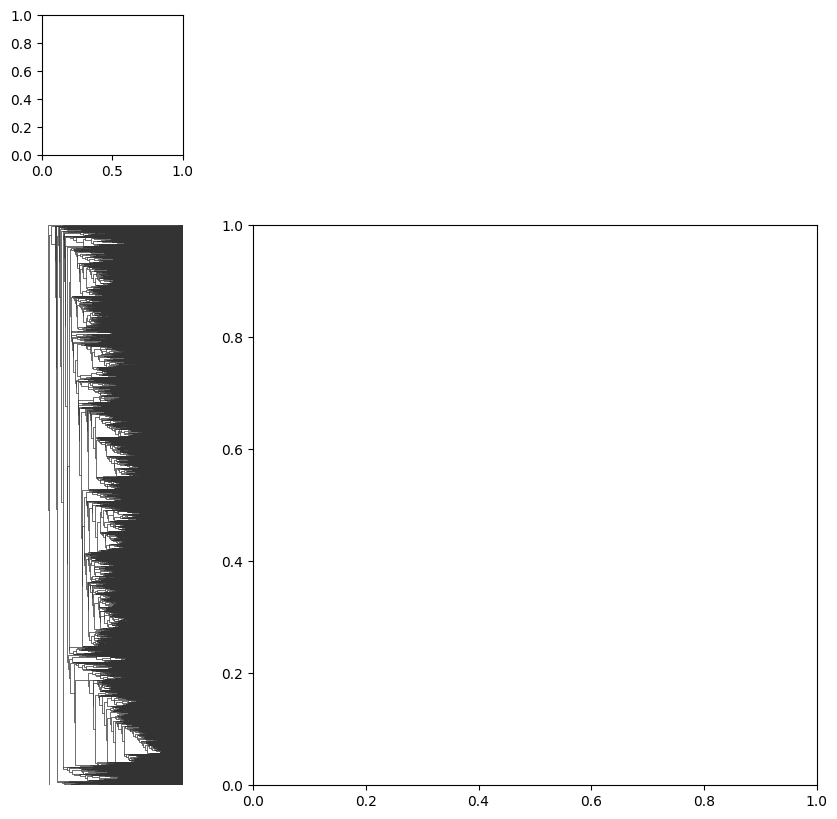

In [15]:
import numpy as np
import seaborn as sns

mpa4_species_profile = mpa4_species_profile.sort_index()
sample_group = sample_group.sort_index()

# random_rows = np.random.randint(0, 6300, size=100)
# random_cols = np.random.randint(0, 2550, size=100)
# sample_group_rand = sample_group.iloc[random_rows, :]
# mpa4_species_profile_rand = mpa4_species_profile.iloc[random_rows, random_cols]

sns.clustermap(mpa4_species_profile, metric="braycurtis")